In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2
using Plots
pyplot()  

cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


## turned on boiling

# the plate code initialization

### Physical parameters

In [2]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Geometry parameters

In [3]:
inch = 2.54e-2;
Lx = 0.1524;
Ly = 0.0648;

In [4]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [5]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((0.7inch,-0.0),0.0)
Te(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((-0.7inch,-0.0),0.0)
Te(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((-2.5inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((2.5inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 1500.0
Tc = 0.0

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

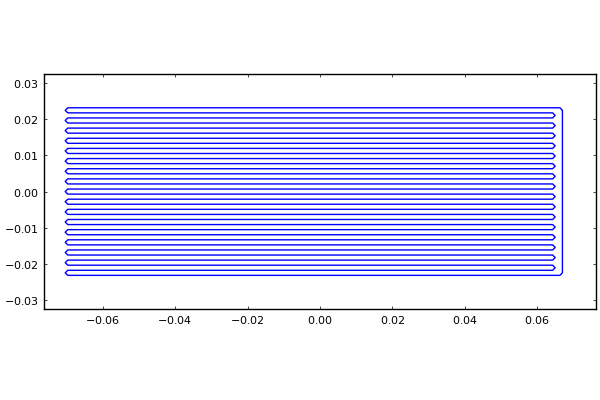

In [6]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = 46.25*1e-3
height = 133.83*1e-3
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)


In [7]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [8]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Initialize state, and create the integrator

In [9]:
u0 = newstate(sys)
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator);

### Set up values for the OHP heat flux per unit length and advance the solution

In [10]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Time marching

In [11]:
num = 1000
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

 14.876028 seconds (3.06 M allocations: 13.261 GiB, 9.85% gc time)


In [12]:
typeof(sys.qline[1].arccoord)

ScalarData{5601,Float64,Array{Float64,1}}

### Plotting temperature contours

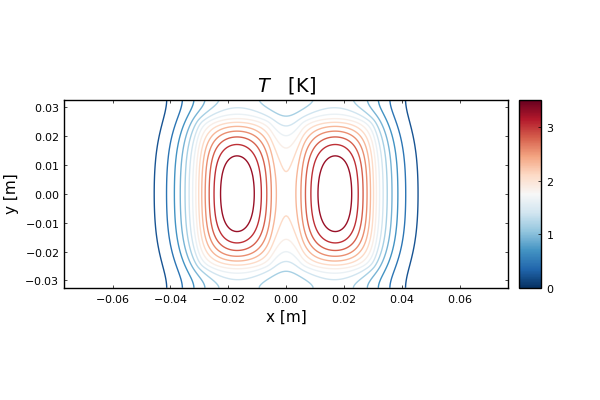

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [13]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [14]:
# plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [15]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [16]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  1.01E+03; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.65E+02;


In [17]:
    d = 6.56e-3 # dimensionless diameter
    L = 34.35  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [18]:
    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [19]:
tube = Tube(d,L,L2D,angle,closedornot);

In [20]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [21]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [50]:
X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)


realratio

0.4593906461497785

In [51]:
N=numpts(ohp)

ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [58]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
# Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δ = 0*zeros(length(X0)) .+ 2.78E-02 .+ 2.78E-02*rand(length(X0)); # use a random film thickness
vapors=Vapor(γ,Hδ,P,δ);

In [61]:
α = 1.154e-5 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
# Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [62]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [63]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [93]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [94]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [95]:
tspan = (0.0, 300.0);
dt_record = tspan[2] /150;

tstep=1e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [96]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
Tplate = temperature(integrator_plate);

In [97]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep*t_to_nondi_t, callback=cbst);

In [98]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

In [99]:
# integrator_plate = plate_hist[end-3]
# integrator_tube = tube_hist[end-3]

# currentsys = integrator_tube.p
# currentsys = getcurrentsys(integrator_tube.u,currentsys);

# tspan = (integrator_plate.t, integrator_plate.t + 1.0);
# dt_record = 0.01

In [100]:
# tspan = (integrator_plate.t, integrator_plate.t + 0.2);
# dt_record = tstep

In [101]:

@time for t in tspan[1]:tstep:tspan[2]
    

#   for j in 1:N_iter
        currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
        currentsys = getcurrentsys(integrator_tube.u,currentsys)


        nondi_qtmp = sys_to_heatflux(currentsys)
        qtmp = nondi_Q_to_Q*nondi_qtmp
        set_linesource_strength!(sys,qtmp)


        Tplate = ADI_timemarching!(Tplate,sys,tstep)
#     end
    integrator_plate.t += tstep
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep*t_to_nondi_t);
    step!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

1.9999999999998905
3.9999999999996705
6.000000000000338
8.000000000001005
9.999999999999897
11.999999999998789
13.99999999999768
15.999999999996572
17.999999999999016
20.00000000000146
merged!
merged!
22.000000000003904
merged!
merged!
24.00000000000635
merged!
26.000000000008793
merged!
28.000000000011237
30.00000000001368
merged!
32.00000000001612
merged!
34.00000000001146
merged!
merged!
merged!
36.0000000000068
38.00000000000214
39.99999999999748
41.999999999992816
merged!
43.999999999988155
merged!
45.999999999983494
merged!
47.99999999997883
49.99999999997417
merged!
51.99999999996951
53.99999999996485
merged!
merged!
55.99999999996019
57.99999999995553
59.999999999950866
merged!
61.999999999946205
63.999999999941544
merged!
65.99999999995109
67.99999999996064
69.99999999997019
71.99999999997974
73.99999999998929
75.99999999999883
78.00000000000838
80.00000000001793
82.00000000002748
84.00000000003703
86.00000000004658
88.00000000005613
merged!
90.00000000006568
92.00000000007523

In [102]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

300.0009999998178


In [103]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [104]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

In [105]:
maximum(temperature(plate_hist[end-5])[:])

6.473993638464454

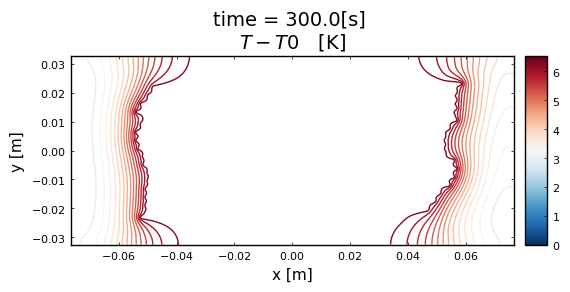

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
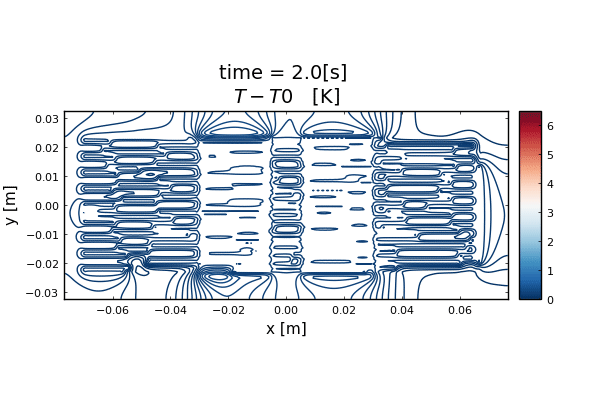

In [120]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = 0.0
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T - T0 \quad [\mathrm{K}]"))
end

In [107]:
minimum(temperature(plate_hist[end]))

2.68508151394171

In [108]:
length(plate_hist)

151

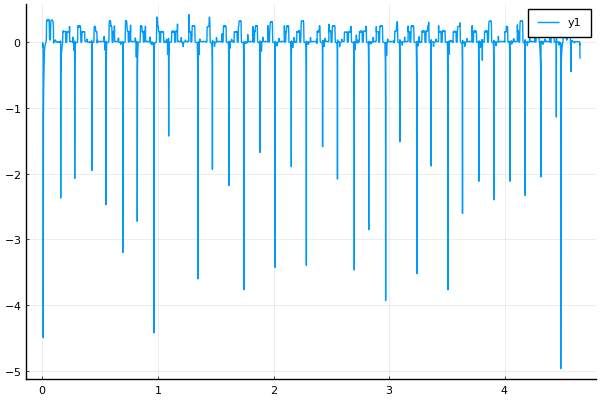

In [109]:
plot(sys.qline[1].arccoord,sys_to_heatflux(sysfinal[end]))

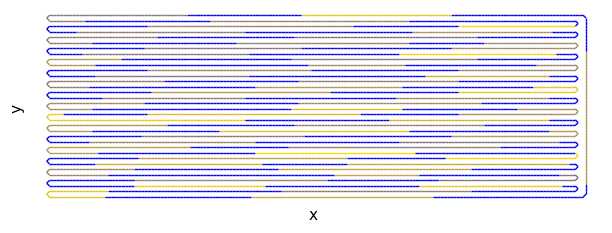

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
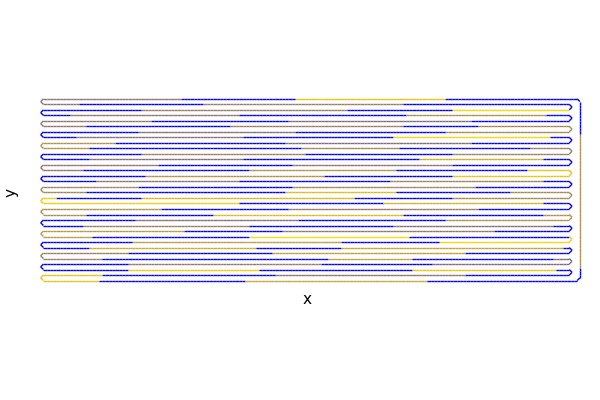

In [124]:
@gif for i=1:1:1
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

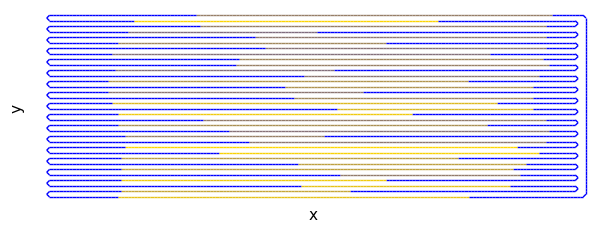

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
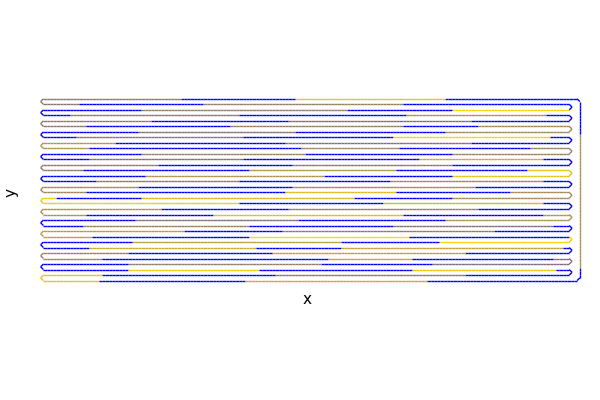

In [110]:
@gif for i=1:10:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

# plot the OHP

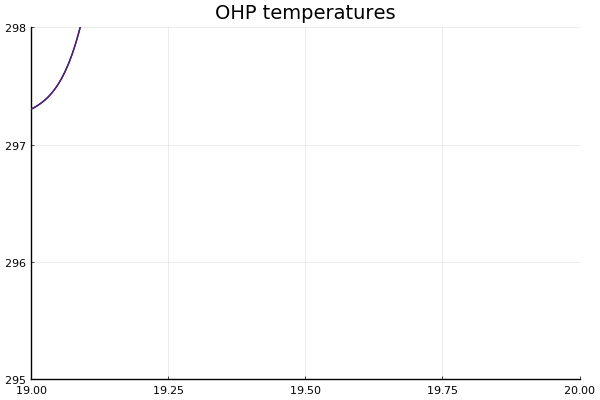

In [111]:
plot(sysfinal[60],xlim=(19.0,20.0),ylim=(295.0,298.0))

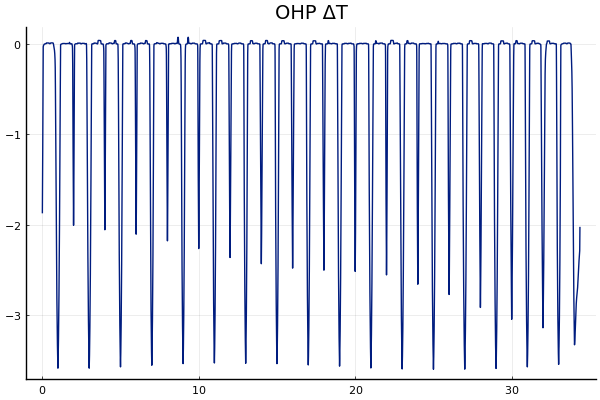

In [125]:
plot(sysfinal[end],plottype="ΔT")

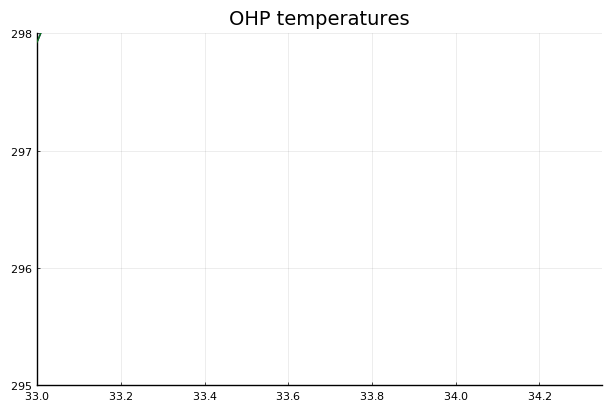

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
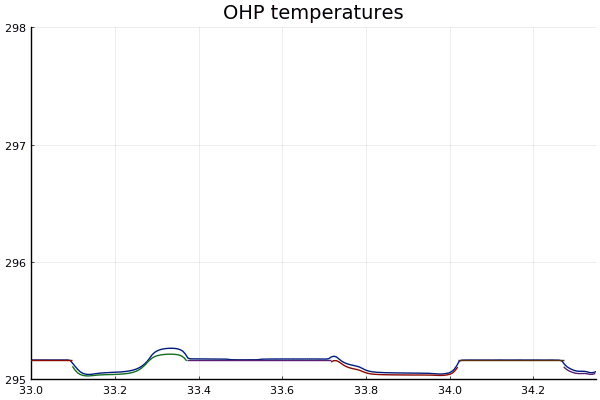

In [112]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="ΔT")
end

In [113]:
sysfinal[end].mapping.H_interp_liquidtowall[8.5:0.01:8.7]

21-element Array{Float64,1}:
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.996635495361
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.996635495358
 10439.99663549536
 10439.99663549536
 10439.99663549536
 10439.99663549536
  1010.0
  1010.0
  1010.0
  1010.0
  1010.0
  1010.0
  1010.0

In [85]:
plot(sysfinal[end-30],plottype="T",xlim=(8.0,9.0))

LoadError: [91mBoundsError: attempt to access 3-element Array{Any,1} at index [-27][39m

In [86]:
plot(sysfinal[end-3],plottype="T",xlim=(8.0,9.0))

LoadError: [91mBoundsError: attempt to access 3-element Array{Any,1} at index [0][39m

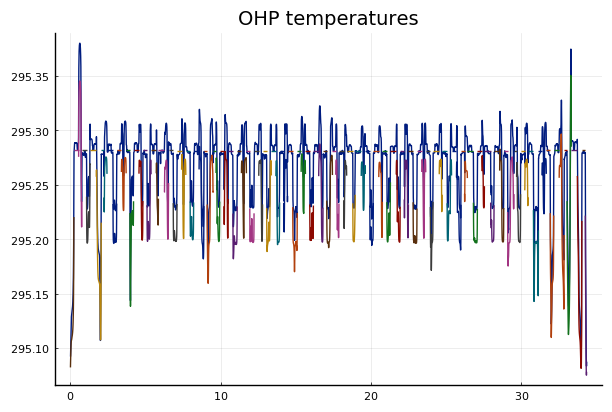

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
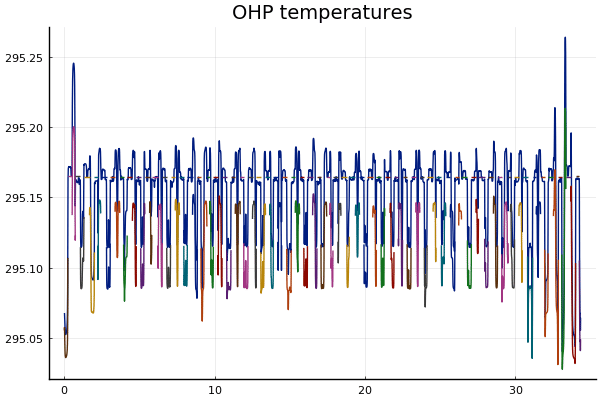

In [87]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii])
end

In [88]:
# plate_hist, integrator_plate = load("plate_OHP_boiling.jld2", "plate_hist",  "integrator_plate")

In [89]:
# tube_hist, integrator_tube = load("tube_OHP_boiling.jld2", "tube_hist",  "integrator_tube")

In [121]:
sysfinal

151-element Array{Any,1}:
 PHPSystem(Tube(0.00656, 34.35, 1.0, 0.0, true), Evaporator([(1.0, 3.0)], [0.0]), Condenser(1.0, [(0.0, 1.0), (3.0, 4.0)], 0.0), Liquid(1010.0, 102.593344, 49.49747468305833, 205000.0, [(32.54453601720788, 32.87223486329217), (33.098457676759686, 33.3715486799519), (33.71666812309055, 34.01928932391535), (34.27266026732117, 0.2373849669960865), (0.5204299730214865, 0.7348304889039808), (1.0725762913723198, 1.3063379368361492), (1.6769574838583285, 2.000035332803219), (2.22403100226265, 2.4178911573003687), (2.808111754488197, 3.0547848207335755), (3.373966880950999, 3.6863254749884757)  …  (26.819966720976545, 27.08146790656823), (27.390689347871863, 27.554879107841302), (27.96785714854444, 28.192136174837344), (28.551736459617885, 28.82405498640142), (29.10546981719274, 29.52660939652013), (29.689389899505922, 29.952646254197784), (30.249368711531805, 30.45976807453069), (30.82420265367165, 31.15309578845822), (31.398131829233815, 31.685125627847892), (31.959

In [122]:
save("plate_OHP2.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [123]:
save("tube_OHP2.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [127]:
inch = 2.54e-2;

# x = [-2.7inch,0.0,2.7inch];
# y = [0.0,0.0,0.0];

x = [-2.7inch]
y = [0.0]

X =  VectorData(x,y);

In [128]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [129]:
ghist = []
thist = []
for i = 1:length(plate_hist)
    H(g,temperature(plate_hist[i]))
    append!(ghist,deepcopy(g))
    append!(thist,plate_hist[i].t)
end

In [130]:
RTDx,RTDy = load("RTD1.jld2","RTDx","RTDy")

([10.3250478, 20.07648184, 36.71128107, 62.52390057, 92.92543021, 126.1950287, 160.6118547, 193.3078394, 227.1510516, 255.2581262, 284.5124283], [16.58290085, 18.92483696, 20.65165341, 21.5397091, 22.03628619, 22.47652622, 22.69333857, 22.79886387, 22.90417577, 23.01055466, 22.94930944])

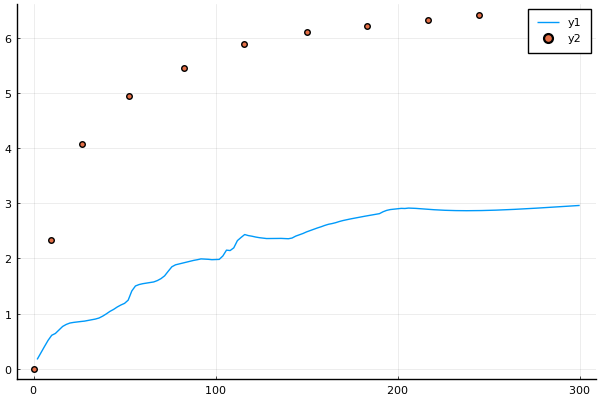

In [131]:
plot(thist,ghist)
scatter!(RTDx .- RTDx[1],RTDy .- RTDy[1])